In [1]:
!pip install yfinance

[*********************100%***********************]  1 of 1 completed

Epoch 1/25



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0012 - val_loss: 7.2331e-04
Epoch 2/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.3357e-05 - val_loss: 0.0012
Epoch 3/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7030e-05 - val_loss: 9.6957e-04
Epoch 4/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.9523e-05 - val_loss: 9.6838e-04
Epoch 5/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.4671e-05 - val_loss: 0.0021
Epoch 6/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.8446e-05 - val_loss: 9.4169e-04
Epoch 7/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.0867e-05 - val_loss: 6.6357e-04
Epoch 8/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.8249e-05 - val_loss: 0.0012
Epoch 9/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.0454e-05 - val_loss: 9.5531e-04
Epoch 10/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8885e-05 - val_loss: 7.6646e-04
Epoch 11/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.2585e-05 - val_loss: 6.9219e-04
Epoch 12/

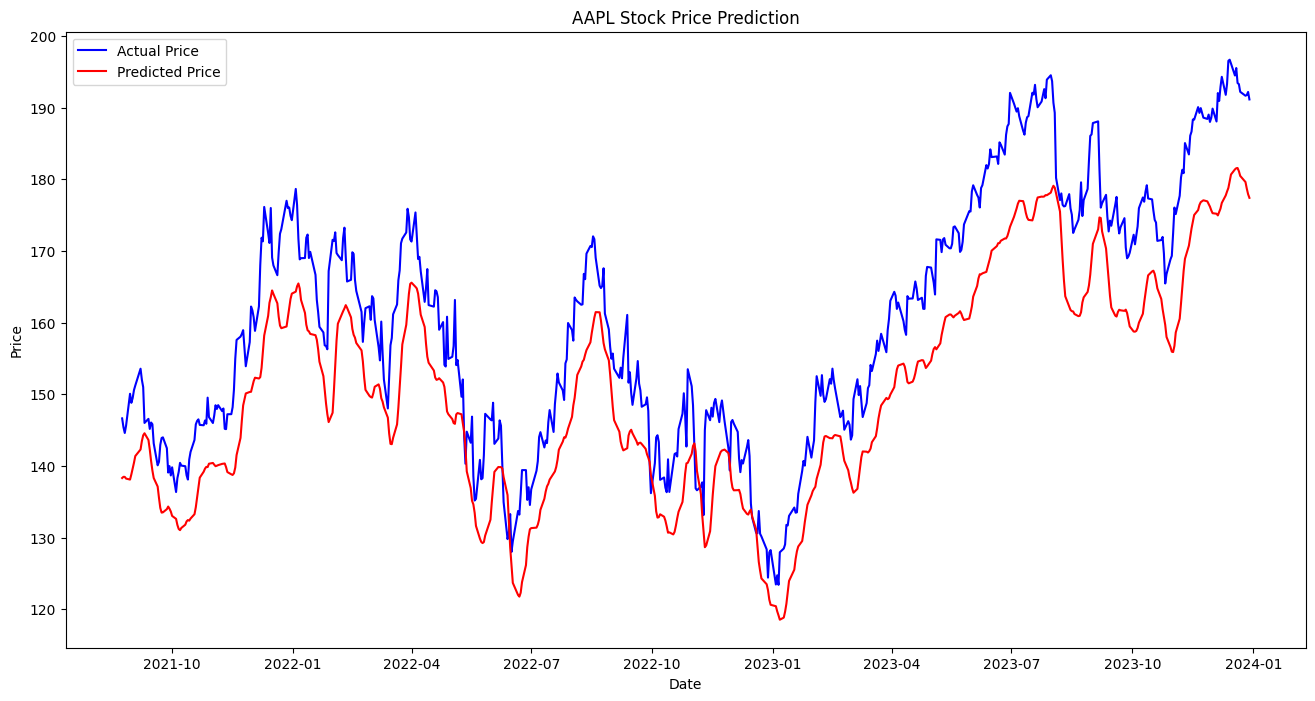

Error plotting moving average: Data must be 1-dimensional, got ndarray of shape (3018, 1) instead
Error plotting RSI: Data must be 1-dimensional, got ndarray of shape (3018, 1) instead


In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# 1. Fetch Data
def fetch_stock_data(symbol, start_date, end_date):
    """
    Fetches stock price data from Yahoo Finance.

    Args:
        symbol (str): The stock symbol (e.g., 'AAPL').
        start_date (str): The start date in 'YYYY-MM-DD' format.
        end_date (str): The end date in 'YYYY-MM-DD' format.

    Returns:
        pandas.DataFrame: The stock price data, or None if an error occurs.
    """
    try:
        data = yf.download(symbol, start=start_date, end=end_date)
        if data.empty:
            print(f"No data found for symbol {symbol} between {start_date} and {end_date}")
            return None
        return data
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

# 2. Prepare Data
def preprocess_data(df):
    """
    Preprocesses the stock price data:
    - Selects the 'Close' price.
    - Scales the data using MinMaxScaler.
    - Creates sequences for LSTM input.

    Args:
        df (pandas.DataFrame): The stock price data.

    Returns:
        tuple: Scaled data, scaler object, and sequences (X, y).  Returns (None, None, None) on error.
    """
    try:
        # Select the 'Close' price
        data = df['Close'].values.reshape(-1, 1)

        # Scale the data
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(data)

        # Create sequences for LSTM
        sequence_length = 60  # Length of the input sequence
        X, y = [], []
        for i in range(len(scaled_data) - sequence_length):
            X.append(scaled_data[i:i + sequence_length])
            y.append(scaled_data[i + sequence_length])
        X, y = np.array(X), np.array(y)
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM input
        return scaled_data, scaler, (X, y)
    except Exception as e:
        print(f"Error preprocessing data: {e}")
        return None, None, None

# 3. Build LSTM Model
def build_lstm_model(input_shape):
    """
    Builds an LSTM model.

    Args:
        input_shape (tuple): The shape of the input data (sequence_length, number of features).

    Returns:
        tensorflow.keras.models.Sequential: The LSTM model, or None on error.
    """
    try:
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
        model.add(LSTM(units=50))
        model.add(Dense(units=1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model
    except Exception as e:
        print(f"Error building LSTM model: {e}")
        return None

# 4. Train and Validate Model
def train_and_validate_model(model, X_train, y_train, epochs=25, batch_size=32, validation_split=0.2):
    """
    Trains and validates the LSTM model.

    Args:
        model (tensorflow.keras.models.Sequential): The LSTM model.
        X_train (numpy.ndarray): The training input data.
        y_train (numpy.ndarray): The training output data.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        validation_split (float): Fraction of data to use for validation.

    Returns:
        tensorflow.keras.callbacks.History: The training history, or None on error.
    """
    try:
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
        return history
    except Exception as e:
        print(f"Error training and validating model: {e}")
        return None

# 5. Plot Predictions vs Actual
def plot_predictions(model, X_test, y_test, scaler, scaled_data, df, symbol):
    """
    Plots the predicted stock prices against the actual prices, including past data.

    Args:
        model (tensorflow.keras.models.Sequential): The trained LSTM model.
        X_test (numpy.ndarray): The test input data.
        y_test (numpy.ndarray): The test output data.
        scaler (MinMaxScaler): The scaler used for data normalization.
        scaled_data (numpy.ndarray):  The entire scaled dataset
        df (pandas.DataFrame): The original dataframe.
        symbol (str): The stock symbol.
    """
    try:
        # Make predictions
        predicted_prices = model.predict(X_test)
        predicted_prices = scaler.inverse_transform(predicted_prices)

        # Inverse transform the y_test data to get the actual prices.
        actual_prices = scaler.inverse_transform(y_test)

        # Create a DataFrame for plotting
        past_days = df.index[-(len(actual_prices)):] # changed this line
        predictions_df = pd.DataFrame({
            'Date': past_days,
            'Actual': actual_prices.flatten(),
            'Predicted': predicted_prices.flatten()
        })

        # Plot the results
        plt.figure(figsize=(16, 8))
        plt.title(f'{symbol} Stock Price Prediction')
        plt.plot(predictions_df['Date'], predictions_df['Actual'], label='Actual Price', color='blue')
        plt.plot(predictions_df['Date'], predictions_df['Predicted'], label='Predicted Price', color='red')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()
    except Exception as e:
        print(f"Error plotting predictions: {e}")

def calculate_rsi(data, window=14):
    """
    Calculates the Relative Strength Index (RSI).

    Args:
        data (pandas.Series):  Stock price data (e.g., closing prices).
        window (int):  The window period for RSI calculation (typically 14).

    Returns:
        pandas.Series: The RSI values.
    """
    delta = data.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)

    # Use rolling average
    ema_up = up.rolling(window=window).mean()
    ema_down = down.rolling(window=window).mean()

    rs = ema_up / ema_down
    rsi = 100 - (100 / (1 + rs))
    return rsi

def plot_rsi(df, symbol):
    """
    Plots the RSI along with stock prices.

    Args:
       df (pandas.DataFrame): The original dataframe.
       symbol (str): The stock symbol.
    """
    try:
        rsi_values = calculate_rsi(df['Close'])

        # Create a DataFrame for plotting
        rsi_df = pd.DataFrame({
            'Date': df.index,
            'Close': df['Close'],
            'RSI': rsi_values
        }).dropna()  # Drop NaN values that result from the RSI calculation

        # Create subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
        fig.suptitle(f'{symbol} Stock Price and RSI')

        # Plot Stock Price
        ax1.plot(rsi_df['Date'], rsi_df['Close'], color='blue')
        ax1.set_ylabel('Price')
        ax1.set_title('Stock Price')

        # Plot RSI
        ax2.plot(rsi_df['Date'], rsi_df['RSI'], color='purple')
        ax2.set_ylabel('RSI')
        ax2.set_title('Relative Strength Index (RSI)')
        ax2.axhline(70, color='red', linestyle='--', alpha=0.7)  # Overbought line
        ax2.axhline(30, color='green', linestyle='--', alpha=0.7)  # Oversold line
        ax2.set_xlabel('Date')

        plt.tight_layout()  # Adjust layout to prevent overlapping
        plt.show()
    except Exception as e:
         print(f"Error plotting RSI: {e}")

def calculate_moving_average(data, window=20):
    """
    Calculates the moving average.

    Args:
        data (pandas.Series): Stock price data.
        window (int): The window period for the moving average.

    Returns:
        pandas.Series: The moving average values.
    """
    return data.rolling(window=window).mean()

def plot_moving_average(df, symbol):
    """
     Plots the moving average along with stock prices.

    Args:
        df (pandas.DataFrame): The stock price data.
        symbol (str): The stock symbol
    """
    try:
        ma_values = calculate_moving_average(df['Close'])

        # Create a DataFrame for plotting
        ma_df = pd.DataFrame({
            'Date': df.index,
            'Close': df['Close'],
            'Moving Average': ma_values
        }).dropna()  # Drop NaN values

        # Plot the results
        plt.figure(figsize=(16, 8))
        plt.title(f'{symbol} Stock Price with Moving Average')
        plt.plot(ma_df['Date'], ma_df['Close'], label='Actual Price', color='blue')
        plt.plot(ma_df['Date'], ma_df['Moving Average'], label='Moving Average', color='green')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()
    except Exception as e:
        print(f"Error plotting moving average: {e}")


def main(symbol='AAPL', start_date='2012-01-01', end_date='2024-01-01', epochs=25, batch_size=32):
    """
    Main function to run the stock price prediction.

    Args:
        symbol (str): The stock symbol (e.g., 'AAPL').
        start_date (str): The start date for the data.
        end_date (str): The end date for the data.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
    """
    # Fetch data
    df = fetch_stock_data(symbol, start_date, end_date)
    if df is None:
        print("Failed to fetch data. Exiting.")
        return

    # Preprocess data
    scaled_data, scaler, (X, y) = preprocess_data(df)
    if scaled_data is None or scaler is None or (X is None or y is None):
        print("Failed to preprocess data. Exiting.")
        return

    # Split data into training and testing sets
    train_size = int(len(X) * 0.8)
    X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

    # Build model
    model = build_lstm_model(input_shape=(X_train.shape[1], 1))
    if model is None:
      print("Failed to build the model")
      return

    # Train model
    history = train_and_validate_model(model, X_train, y_train, epochs, batch_size)
    if history is None:
        print("Failed to train the model. Exiting.")
        return

    # Evaluate the model (optional)
    # You can add code here to evaluate the model's performance on the test set

    # Plot predictions
    plot_predictions(model, X_test, y_test, scaler, scaled_data, df, symbol)

    # Plot Moving Average
    plot_moving_average(df, symbol)

    # Plot RSI
    plot_rsi(df, symbol)

if __name__ == "__main__":
    main()